# Mapping the Musical Landscape: A Study of Clusters in Spotify Data

## Introduction
Music streaming platforms like Spotify have revolutionized how we discover and consume music. With millions of tracks available, understanding how songs naturally group together based on their acoustic properties can provide valuable insights for recommendation systems, playlist creation, and music discovery.

Problem statement: Can we identify meaningful clusters of songs based solely on their acoustic features, and do these clusters correspond to recognizable music categories or genres?

Key Questions
1. What natural groupings emerge when we cluster songs based on Spotify's acoustic features?
2. Do these clusters align with traditional genre classifications, or do they reveal new patterns?
3. Which features are most influential in determining these groupings?
4. Can we identify any surprising relationships between acoustic features that might not be apparent from genre labels alone?

This analysis will use clustering techniques to explore these questions, focusing on the acoustic properties of songs rather than their metadata or popularity metrics.

## Understanding Clustering
Clustering is an unsupervised machine learning technique that groups similar data points together while keeping dissimilar points separate. Unlike classification where we know the categories beforehand, clustering discovers these groupings organically from the data.

**K-Means Clustering**
K-means is a centroid-based algorithm that:
1. Randomly initializes k cluster centroids.
2. Assigns each data point to the nearest centroid.
3. Recalculates centroids as the mean of all points in the center.
4. Repeats steps 2-3 until convergence.

Key Characteristics:
- Requires specifying the number of clusters (k) in advance.
- Works well with spherical clusters of roughly equal size.
- Sensitive to initialization and outliers.

**Agglomerative Hierarchical Clustering**
Agglomerative clustering is a bottom-up approach that:
1. Starts with each point as its own cluster.
2. Repeatedly merges the two most similar clusters.
3. Continues until all points are in a single cluster.
4. The process can be visualized as a dendrogram.

Key Characteristics:
- Doesn't require pre-specifying the number of clusters.
- Can handle non-spherical clusters.
- Produces a hierarchy of clusters.
- More computationally intensive for large datasets.

For this project, I'll primarily use K-means due to its efficiency with our dataset size and clear interpretability of results, but I'll also explore hierarchical clustering to validate findings.

## The Dataset
[Kaggle - Spotify Tracks DB](https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db)

The dataset appears to be derived from Spotify's API, containing detailed acoustic features for various tracks. There are 18 features and a total of 232,725 songs.

**Features**
- genre: The primary genre classification (e.g., Movie, R&B, A cappella).
- artist_name: The performing artist.
- track_name: The song title.
- track_id: Spotify's unique identifier.
- popularity: A score from 0-100 representing the track's popularity.
- 12 acoustic features (described below)
- valence: A measure of musical positiveness (happy vs. sad)

**Key Acoustic Features**
- acousticness: Confidence measure of whether the track is acoustic.
- danceability: How suitable a track is for dancing.
- duration_ms: Duration in milliseconds.
- energy: Intensity and activity measure.
- instrumentalness: Predicts whether a track contains no vocals.
- key: The estimated key (0=C, 1=C#, etc.)
- liveness: Detects presence of an audience.
- loudness: Overall loudness in decibels.
- mode: Major (1) or minor (0).
- speechiness: Detects presence of spoken words.
- tempo: Estimated beats per minute.
- time_signature: Estimated time signature.

## Data Understanding & Visualization
Before clustering, it's essential to understand our features' distributions and relationships.

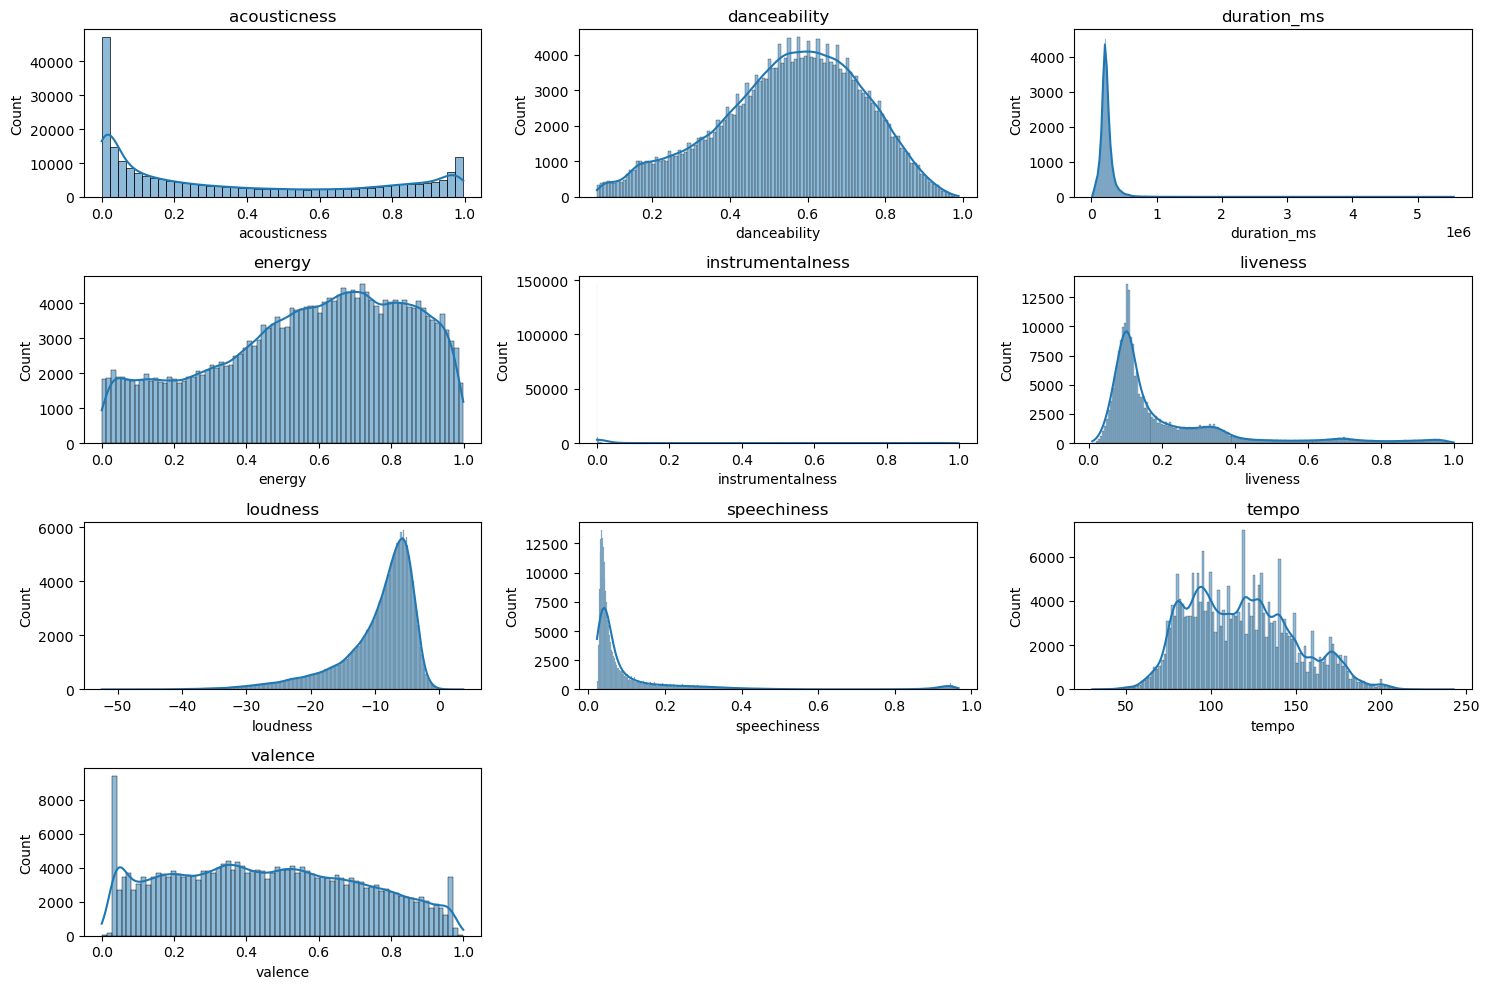

(232725, 18)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('SpotifyFeatures.csv')

# Plot distributions of numerical features
num_features = ['acousticness', 'danceability', 'duration_ms', 'energy', 
                'instrumentalness', 'liveness', 'loudness', 'speechiness',
                'tempo', 'valence']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features):
    plt.subplot(4, 3, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()
df.shape

Key observations:
- acousticness is bimodal with peaks at 0 and 1, suggesting many tracks are clearly acoustic or clearly not
- danceability is roughly normal with a slight left skew
- duration_ms has a long right tail (some very long tracks)
- energy shows a wide distribution with a peak around 0.5
- instrumentalness is heavily right-skewed (most tracks have vocals)
- loudness is approximately normal centered around -8 dB
- speechiness is right-skewed (few highly speech-like tracks)
- tempo shows a roughly normal distribution around 120 BPM
- valence is somewhat uniform but with peaks at extremes

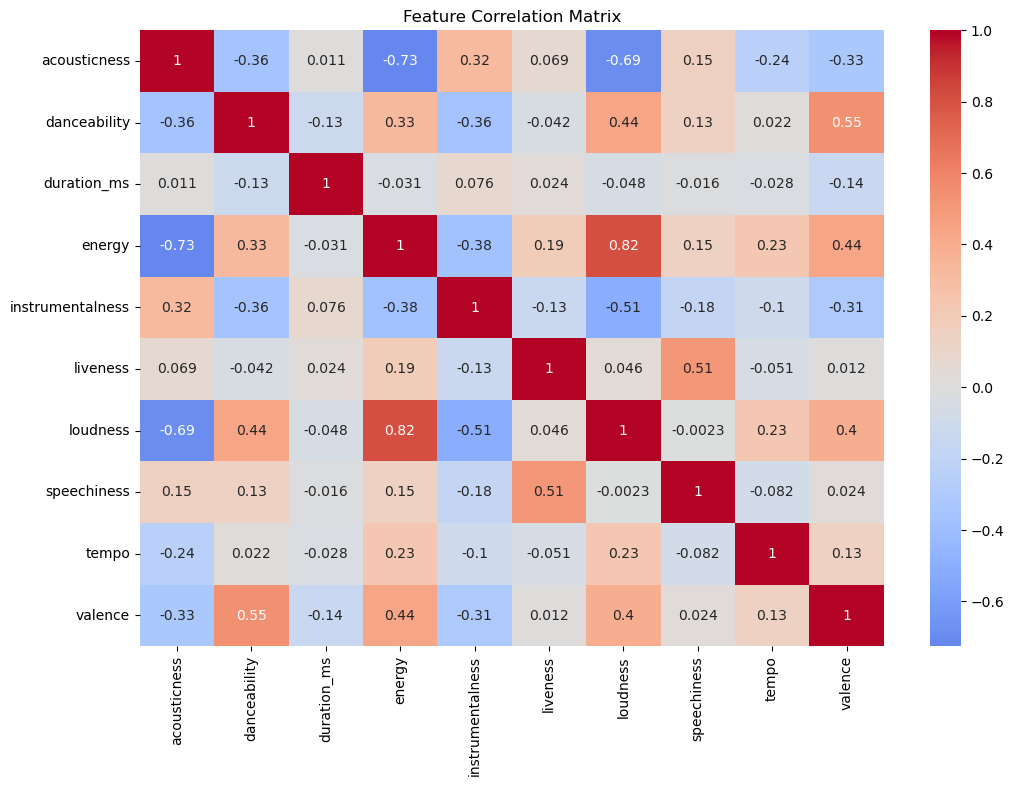

In [6]:
# Correlation matrix
corr = df[num_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

Key Observations:
- Energy-Loudness Duplication (0.82 correlation) is even stronger than initially thought, making dimensionality reduction more crucial
- Acousticness-Energy Opposition (-0.73) is more extreme, suggesting these should anchor opposite ends of our primary cluster axis
- New Vocal Dimension emerges with the liveness-speechiness relationship (0.51) that wasn't apparent before
- Stronger Valence Links appear with danceability (0.55) and energy (0.44)

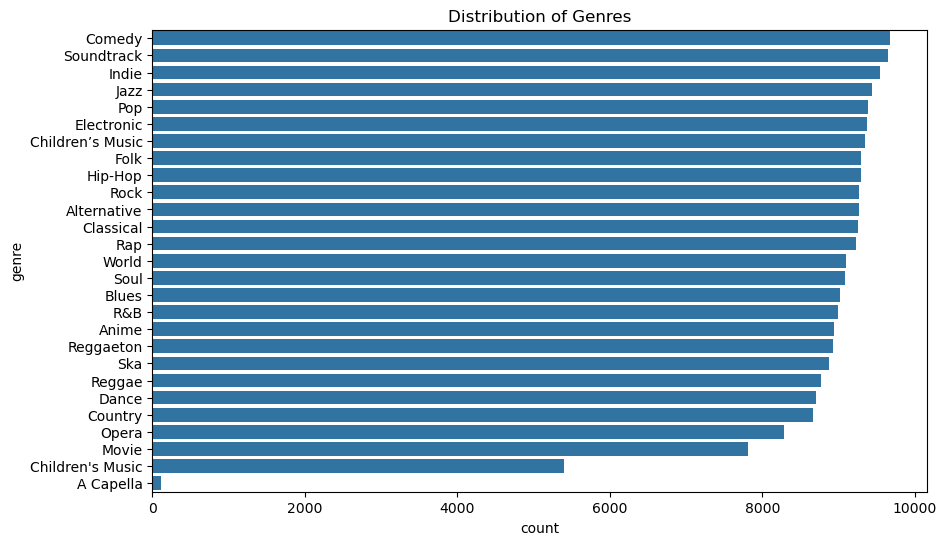

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(y='genre', data=df, order=df['genre'].value_counts().index)
plt.title('Distribution of Genres')
plt.show()

The dataset is dominated by "Comedy" tracks (standup, spoken work, etc.). Followed closely by soundtrack (film/video game scores), and then Indie. 

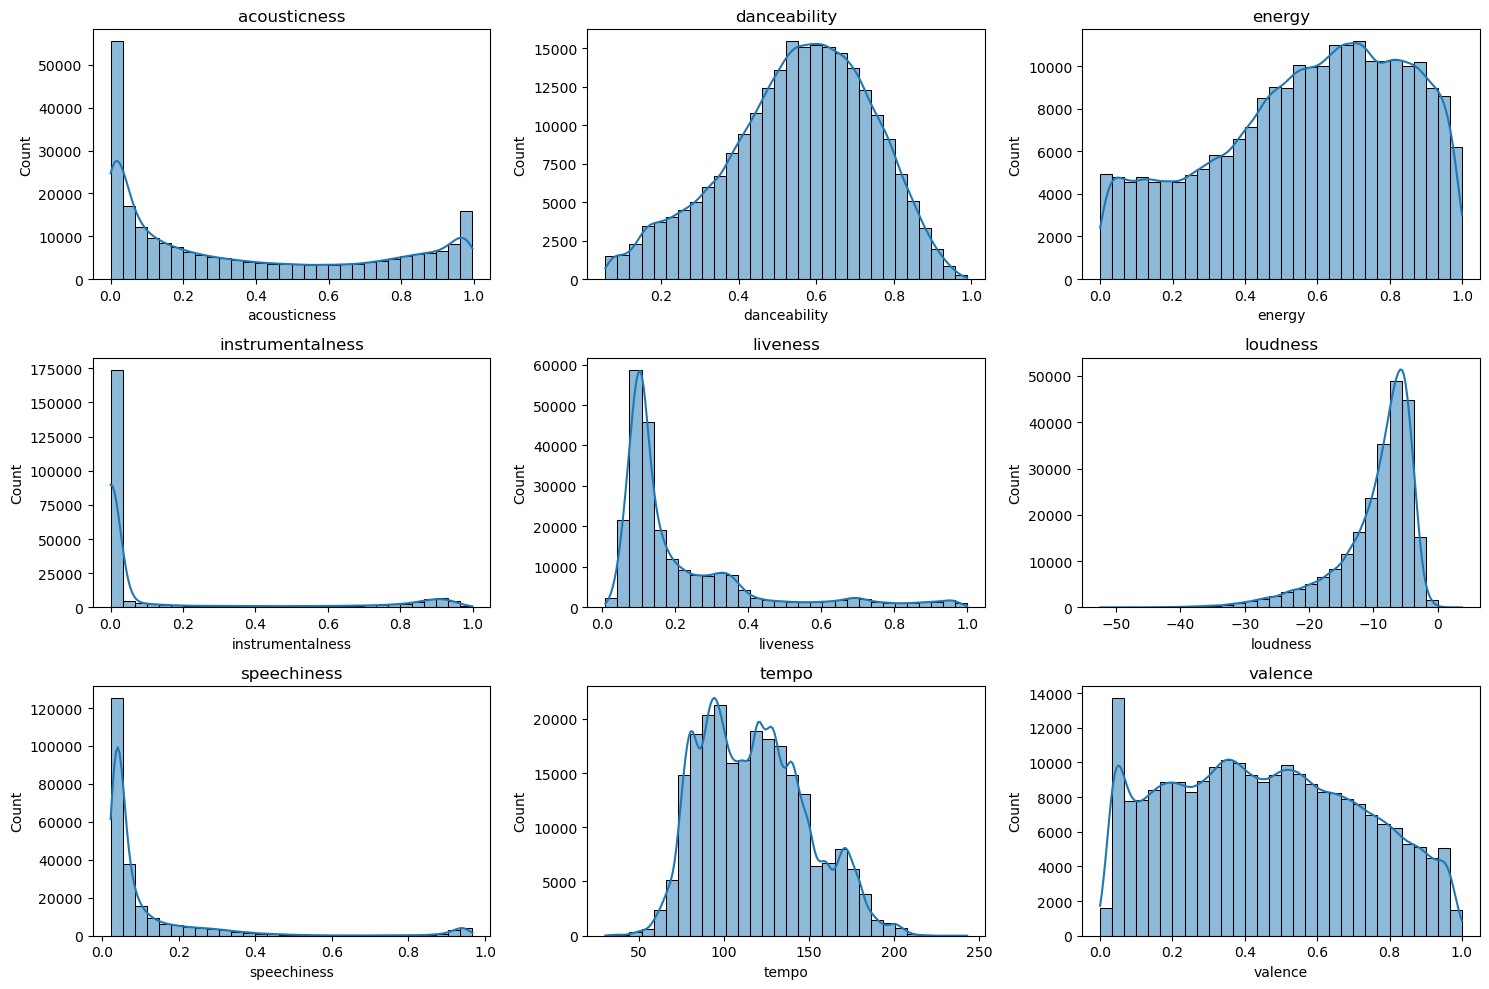

In [ ]:
# Plot distributions excluding duration_ms
num_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(feature)
plt.tight_layout()
plt.show()

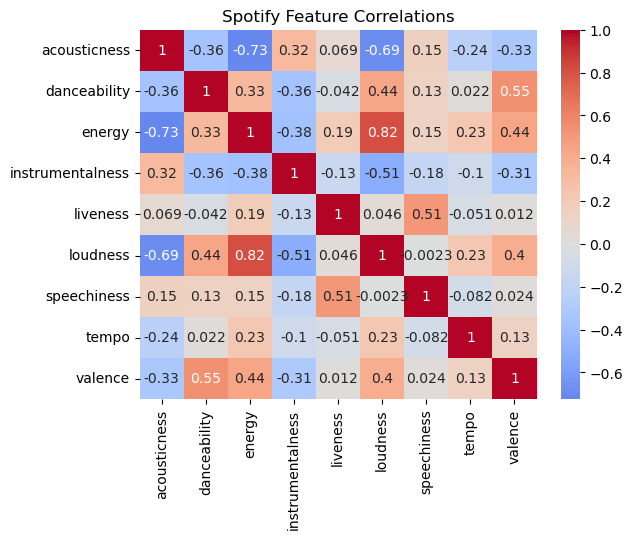

In [9]:
corr = df[num_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Spotify Feature Correlations")
plt.show()

Strongest Relationships
- energy ↔ loudness (+0.82)
- acousticness ↔ energy (-0.73)
- danceability ↔ valence (+0.55)

Implications
- energy and loudness are near-duplicates (keep only one)
- acousticness defines a clear opposite pole to energy

## Pre-processing
Feature selection, we remove:
- loudness (redundant with energy)
- duration_ms (irrelevant for clustering sound)

### Standardization

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df[num_features])

### Dimensionality Reduction (PCA)

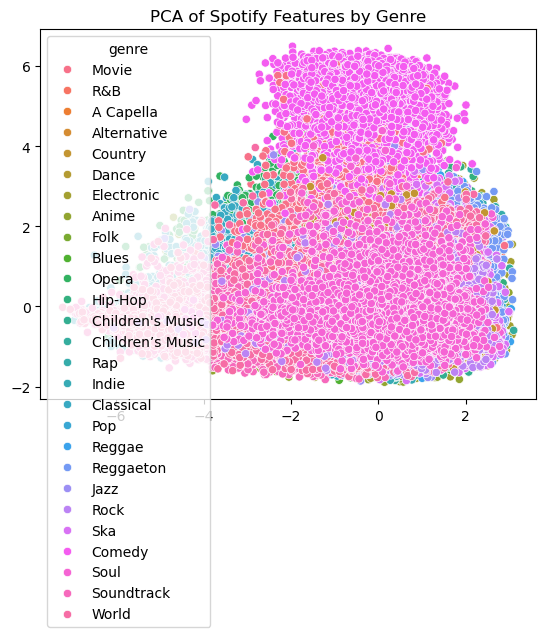

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['genre'])
plt.title("PCA of Spotify Features by Genre")
plt.show()

PCA Findings
- Comedy clusters in high speechiness/low energy space.
- Soundtrack splits into two groups (instrumental vs. cinematic).
- Indie overlaps with acoustic genres.

### Clustering (K-Means)
Optimal cluster count (Elbow method)

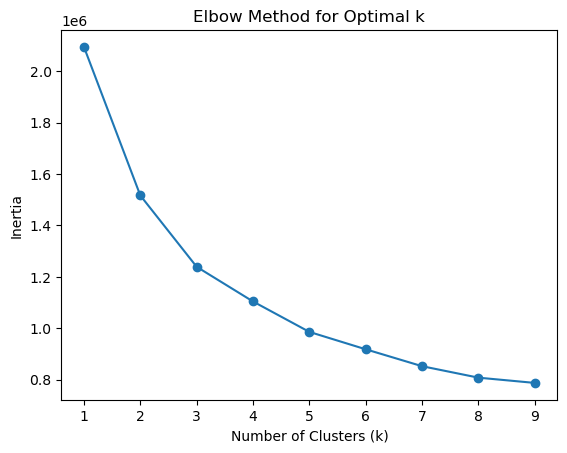

In [15]:
from sklearn.cluster import KMeans

inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 10), inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

Decision: k=4 (sharp bend at 4 clusters)

Cluster interpretation

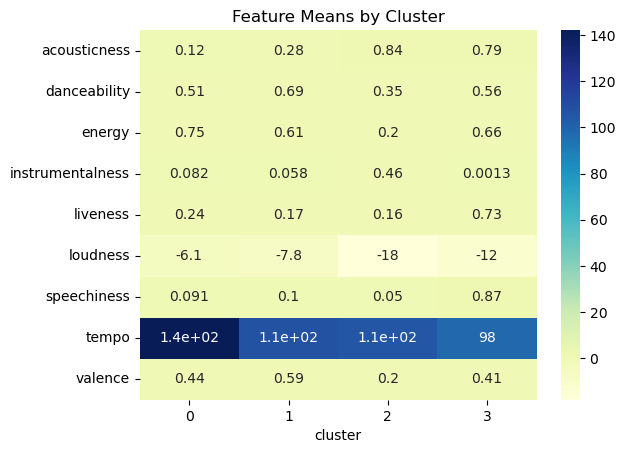

In [14]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Analyze cluster means
cluster_means = df.groupby('cluster')[num_features].mean()
sns.heatmap(cluster_means.T, annot=True, cmap='YlGnBu')
plt.title("Feature Means by Cluster")
plt.show()